<a href="https://colab.research.google.com/github/alamau01/Thesis-in-EE/blob/master/Stock_Price_Prediction_LSTM_Keras_Credit_Suisse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

dataset = web.DataReader('CS', data_source = 'yahoo', start = '2000-01-01', end = '2020-03-31')
dataset

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,48.583984,48.339844,48.339844,48.339844,2000.0,26.217627
2000-01-04,47.607422,46.630859,46.875000,46.875000,6400.0,25.423159
2000-01-05,47.363281,46.386719,46.875000,46.875000,13000.0,25.423159
2000-01-06,47.119141,46.386719,47.119141,47.119141,1400.0,25.555563
2000-01-07,47.241211,46.386719,47.241211,47.241211,2200.0,25.621771
...,...,...,...,...,...,...
2020-03-25,8.560000,7.890000,8.150000,8.260000,6514800.0,8.260000
2020-03-26,8.970000,8.490000,8.530000,8.890000,7800400.0,8.890000
2020-03-27,8.540000,8.170000,8.370000,8.330000,3725100.0,8.330000


In [0]:
dataset.shape

(5093, 6)

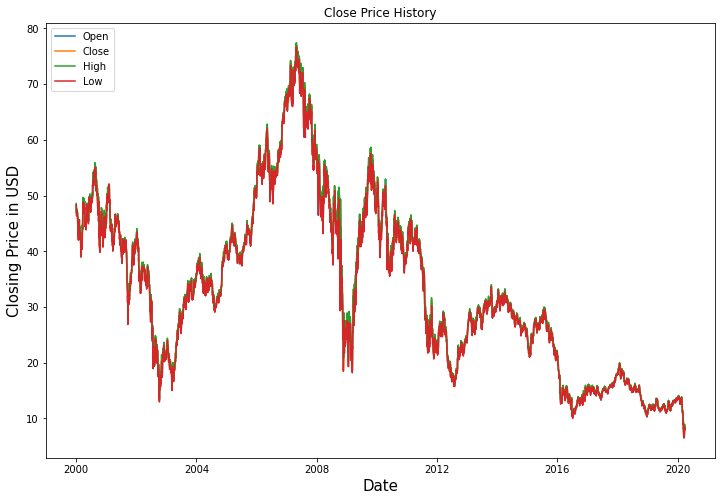

In [0]:
plt.figure(figsize = (12, 8))
plt.plot(dataset['Open'])
plt.plot(dataset['Close'])
plt.plot(dataset['High'])
plt.plot(dataset['Low'])
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price in USD', fontsize = 15)
plt.title('Close Price History')
plt.legend(['Open', 'Close', 'High', 'Low'], loc = 'upper left')
plt.show()

In [0]:
close_price = dataset.filter(['Close']).values
data_train_len = math.ceil(len(close_price) * .8)

sc = MinMaxScaler(feature_range = (0, 1))
sc_data = sc.fit_transform(close_price)

data_train = sc_data[0 : data_train_len, : ]
xtrain = []
ytrain = []
for i in range(60, len(data_train)):
    xtrain.append(data_train[i - 60 : i, 0])
    ytrain.append(data_train[i, 0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
xtrain.shape

(4015, 60, 1)

In [0]:
model = Sequential()
model.add(LSTM(units = 512, return_sequences = True, input_shape = (xtrain.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 512, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 512, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 512, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'nadam', loss = 'mean_squared_error')
model.fit(xtrain, ytrain, batch_size = 128, epochs = 150)

Epoch 1/150
32/32 [==============================] - 4s 139ms/step - loss: 0.1086
Epoch 2/150
32/32 [==============================] - 4s 138ms/step - loss: 0.0129
Epoch 3/150
32/32 [==============================] - 4s 138ms/step - loss: 0.0025
Epoch 4/150
32/32 [==============================] - 4s 138ms/step - loss: 0.0022
Epoch 5/150
32/32 [==============================] - 4s 139ms/step - loss: 0.0021
Epoch 6/150
32/32 [==============================] - 4s 139ms/step - loss: 0.0023
Epoch 7/150
32/32 [==============================] - 4s 138ms/step - loss: 0.0021
Epoch 8/150
32/32 [==============================] - 4s 138ms/step - loss: 0.0018
Epoch 9/150
32/32 [==============================] - 4s 138ms/step - loss: 0.0021
Epoch 10/150
32/32 [==============================] - 4s 138ms/step - loss: 0.0012
Epoch 11/150
32/32 [==============================] - 4s 139ms/step - loss: 0.0027
Epoch 12/150
32/32 [==============================] - 4s 140ms/step - loss: 0.0012
Epoch 13/150


In [0]:
data_test = sc_data[data_train_len - 60 : , :]
xtest = []
ytest = close_price[data_train_len :, :]
for i in range(60, len(data_test)):
    xtest.append(data_test[i - 60 : i, 0])

xtest = np.array(xtest)
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

In [0]:
close_price_pred = model.predict(xtest)
close_price_pred = sc.inverse_transform(close_price_pred)
rmse_score = np.sqrt(np.mean(((close_price_pred - ytest) ** 2)))
rmse_score

0.3861981548870023

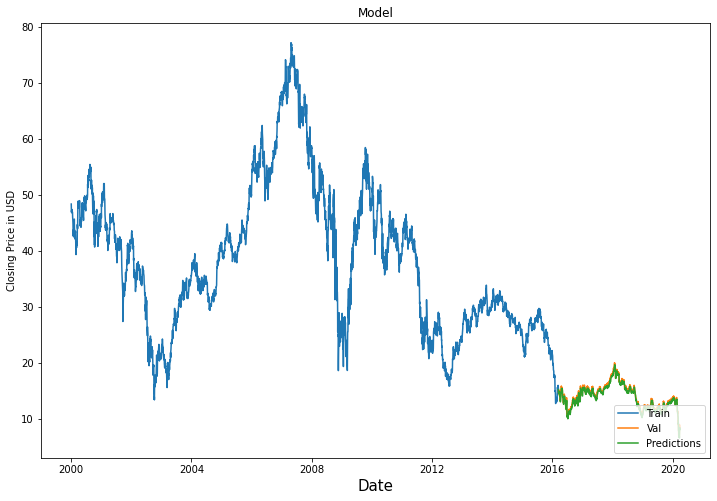

In [0]:
train = dataset.filter(['Close'])[: data_train_len]
valid = dataset.filter(['Close'])[data_train_len :]
valid['Predictions'] = close_price_pred

plt.figure(figsize = (12, 8))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price in USD')
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.title('Model')
plt.show()

In [0]:
valid

,Close,Predictions
Date,,
2016-03-16,14.64,15.195143
2016-03-17,14.78,14.591522
2016-03-18,15.12,14.506388
2016-03-21,15.04,14.771596
2016-03-22,14.75,14.816252
...,...,...
2020-03-25,8.26,7.197859
2020-03-26,8.89,7.772642
2020-03-27,8.33,8.376019


In [0]:
cs_stock_price = web.DataReader('CS', data_source = 'yahoo', start = '2000-01-01', end = '2020-03-31')
new_dataset = cs_stock_price.filter(['Close'])
last_60_days = new_dataset[-60 :].values
last_60_days_sc = sc.transform(last_60_days)
xtest1 = []
xtest1.append(last_60_days_sc)
xtest1 = np.array(xtest1)
xtest1 = np.reshape(xtest1, (xtest1.shape[0], xtest1.shape[1], 1))
pred_price = model.predict(xtest1)
pred_price = sc.inverse_transform(pred_price)
print(pred_price)

[[8.132435]]


In [0]:
cs_stock_2 = web.DataReader('CS', data_source = 'yahoo', start = '2020-04-01', end = '2020-04-02')
print(apple_stock_2['Close'])

NameError: ignored